In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import display, Markdown

# ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Lataa aineisto (vaihda 'your_dataset.csv' tiedoston polkuun Kagglesta)
house_data = pd.read_csv('../data/house_data_train.csv')
# Checking for missing values in the dataset
missing_values = house_data.isnull().sum()

# Displaying columns with missing values and the number of missing values in each
missing_values = missing_values[missing_values > 0]




In [2]:
# Lasketaan kuvailevat tilastot datasetille
descriptive_stats = house_data.describe()
descriptive_stats
# Lasketaan keskeiset kuvailevat arvot ja tallennetaan ne muuttujiksi
price_mean = house_data['price'].mean()
price_min = house_data['price'].min()
price_max = house_data['price'].max()

bedrooms_mean = house_data['bedrooms'].mean()

grade_mean = house_data['grade'].mean()
grade_min = house_data['grade'].min()
grade_max = house_data['grade'].max()

living_area_mean = house_data['living_in_m2'].mean()
living_area_min = house_data['living_in_m2'].min()
living_area_max = house_data['living_in_m2'].max()

bathrooms_mean = house_data['real_bathrooms'].mean()
bathrooms_min = house_data['real_bathrooms'].min()
bathrooms_max = house_data['real_bathrooms'].max()


In [3]:
display(Markdown(f"""
Tässä ovat datasetin keskeiset tunnusluvut:

- **Hinta (price)**: Keskiarvo on noin {price_mean:.2f}, ja hinnat vaihtelevat {price_min} ja {price_max} välillä.
- **Huoneluku (bedrooms)**: Keskimääräinen huoneluku on {bedrooms_mean:.2f}.
- **Grade (grade)**: Luokitusten keskiarvo on {grade_mean:.2f}, ja arvot vaihtelevat välillä {grade_min}–{grade_max}.
- **Asunnon koko (living_in_m2)**: Pinta-alan keskiarvo on noin {living_area_mean:.2f} m², vaihdellen {living_area_min} ja {living_area_max} välillä.
- **Kylpyhuoneet (real_bathrooms)**: Keskimääräinen kylpyhuonemäärä on {bathrooms_mean:.2f}, ja määrä vaihtelee {bathrooms_min} ja {bathrooms_max} välillä.
"""))



Tässä ovat datasetin keskeiset tunnusluvut:

- **Hinta (price)**: Keskiarvo on noin 475286.09, ja hinnat vaihtelevat 81000.0 ja 1155000.0 välillä.
- **Huoneluku (bedrooms)**: Keskimääräinen huoneluku on 2.24.
- **Grade (grade)**: Luokitusten keskiarvo on 2.53, ja arvot vaihtelevat välillä 1–5.
- **Asunnon koko (living_in_m2)**: Pinta-alan keskiarvo on noin 181.75 m², vaihdellen 49.23859 ja 391.12163 välillä.
- **Kylpyhuoneet (real_bathrooms)**: Keskimääräinen kylpyhuonemäärä on 1.68, ja määrä vaihtelee 1 ja 3 välillä.


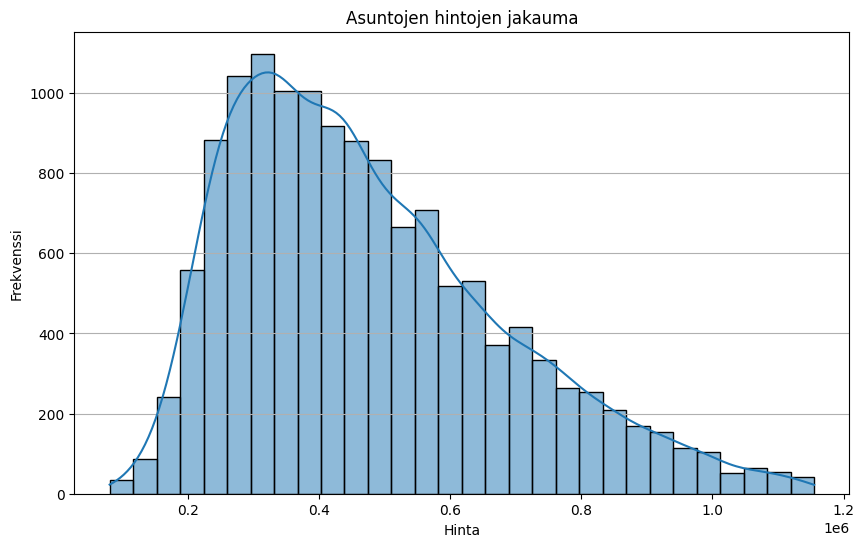

In [4]:
# Luodaan histogrammi asuntojen hintojen jakauman visualisoimiseksi
plt.figure(figsize=(10, 6))
sns.histplot(house_data['price'], bins=30, kde=True)
plt.title("Asuntojen hintojen jakauma")
plt.xlabel("Hinta")
plt.ylabel("Frekvenssi")
plt.grid(axis='y')
plt.show()


Tässä on histogrammi, joka kuvaa asuntojen hintojen jakaumaa. Histogrammissa on myös kernel density estimation (KDE) -käyrä, joka antaa visuaalista tietoa hintojen tiheydestä. 

### Huomioita histogrammista:
- **Hintojen keskittyminen**: Voimme huomata, että suurin osa asunnoista on hinnoiteltu noin 200 000 - 600 000 euron välille, mikä on tyypillistä alueilla, joissa asunnot sijaitsevat.
- **Vinouma**: Histogrammi saattaa osoittaa lievää vinoumaa oikealle, koska kalleimmat asunnot (yli 800 000 euroa) ovat huomattavasti harvinaisempia.
- **Poikkeamat**: Onko havaittavissa hintapisteitä, jotka poikkeavat selvästi muista? Nämä voivat olla erityisiä tapauksia tai virheitä datassa.


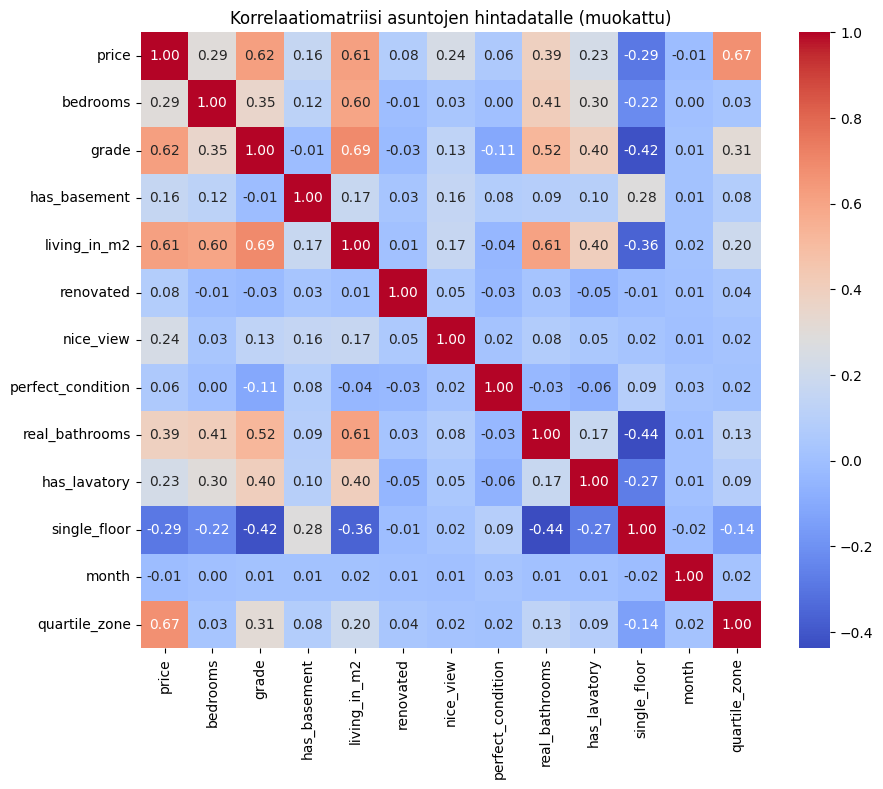

In [5]:
# Luodaan kopio datasta ja muunnetaan boolean-arvot numeerisiksi
house_data_copy = house_data.copy()
house_data_copy = house_data_copy.replace({True: 1, False: 0})
house_data_copy = house_data_copy.infer_objects(copy=False)


# Poistetaan 'date'-sarakkeen kopioidusta datasetistä
house_data_copy.drop(columns=['date'], inplace=True)

# Lasketaan korrelaatiomatriisi uudelleen
correlation_matrix_copy = house_data_copy.corr()

# Piirretään korrelaatiomatriisi lämpökarttana
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_copy, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korrelaatiomatriisi asuntojen hintadatalle (muokattu)")
plt.show()



### Korrelaatiomatriisin tulkinta

Korrelaatiomatriisi näyttää, miten datasetin muuttujat korreloivat keskenään. Korrelaatiokerroin voi vaihdella -1 ja 1 välillä:
- **Positiivinen korrelaatio** (lähellä 1) tarkoittaa, että kun toisen muuttujan arvo kasvaa, myös toisen arvo yleensä kasvaa. Esimerkiksi asunnon koon ja hinnan välillä voisi odottaa positiivista korrelaatiota.
- **Negatiivinen korrelaatio** (lähellä -1) tarkoittaa, että kun toisen muuttujan arvo kasvaa, toisen arvo tyypillisesti laskee.
- **Korrelaatiokertoimen arvo lähellä 0** viittaa siihen, ettei merkittävää yhteyttä muuttujien välillä ole.

#### Hintaan (price) liittyvät korrelaatiot
Tarkastelemalla hintaan liittyviä korrelaatioita voidaan nähdä, mitkä tekijät vaikuttavat eniten asunnon hintaan. Jos esimerkiksi **asunnon koko (living_in_m2)** on vahvasti positiivisesti korreloitunut hintaan, tämä viittaa siihen, että suuremmat asunnot ovat tyypillisesti kalliimpia. Myös muut muuttujat, kuten **huoneluku (bedrooms)** ja **kunto (grade)**, saattavat vaikuttaa hintaan, ja korkea korrelaatio voi osoittaa näiden muuttujien merkittävyyttä hintaa ennustettaessa.

#### Muuttujien keskinäiset yhteydet
Korrelaatiomatriisista voidaan myös nähdä muuttujien välisiä keskinäisiä suhteita. Esimerkiksi asunnon koon (living_in_m2) ja huoneluvun (bedrooms) välinen vahva korrelaatio on looginen, sillä suuremmissa asunnoissa on usein enemmän huoneita. Tällaiset yhteydet ovat hyödyllisiä, koska ne voivat auttaa valitsemaan malliin vain oleellisimmat muuttujat ja välttämään päällekkäisyyksiä.

Näiden havaintojen perusteella voimme tunnistaa keskeiset tekijät, jotka kannattaa ottaa huomioon ennustemallissa, jotta saadaan mahdollisimman tarkka malli asuntojen hintojen ennustamiseen.

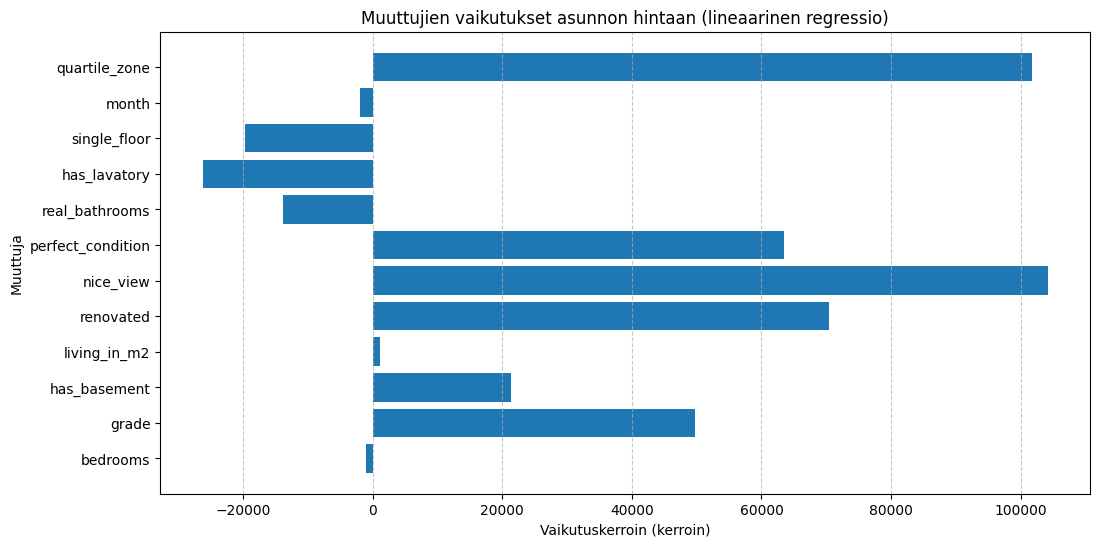

In [6]:
# Selecting features and target variable for the model
# Dropping non-numeric and irrelevant features (like date) for the linear regression model
house_data_copy = house_data.copy()
house_data_copy = house_data_copy.replace({True: 1, False: 0})
house_data_copy = house_data_copy.infer_objects(copy=False)

X = house_data_copy.drop(columns=['price', 'date'])
y = house_data_copy['price']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building and training the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Getting the coefficients for each feature
coefficients = model.coef_
feature_names = X.columns

# Creating a bar plot to visualize the feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_names, coefficients)
plt.xlabel("Vaikutuskerroin (kerroin)")
plt.ylabel("Muuttuja")
plt.title("Muuttujien vaikutukset asunnon hintaan (lineaarinen regressio)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()
